[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  4 of 4 completed
NaN in data! Fixed.
[[0.14726591 0.00740369 0.28348061 0.90560406]
 [0.14726591 0.00740369 0.28348061 0.90560406]
 [0.16287018 0.00718103 0.28348061 0.93958657]
 ...
 [0.77007934 0.87085282 0.16723317 0.74721776]
 [0.76770556 0.87096412 0.16723317 0.75616054]
 [0.76770556 0.87096412 0.17036029 0.75616054]]


array([[0.13296747, 0.13296747, 0.12935341, ..., 0.14178052, 0.1433436 ,
        0.1433436 ],
       [0.13296747, 0.12935341, 0.12935341, ..., 0.1433436 , 0.1433436 ,
        0.14733871],
       [0.12935341, 0.12935341, 0.134033  , ..., 0.1433436 , 0.14733871,
        0.14733871],
       ...,
       [0.80465432, 0.79665924, 0.79665924, ..., 0.75404546, 0.75404546,
        0.77007934],
       [0.79665924, 0.79665924, 0.79369082, ..., 0.75404546, 0.77007934,
        0.77007934],
       [0.79665924, 0.79369082, 0.79369082, ..., 0.77007934, 0.77007934,
        0.76770556]])

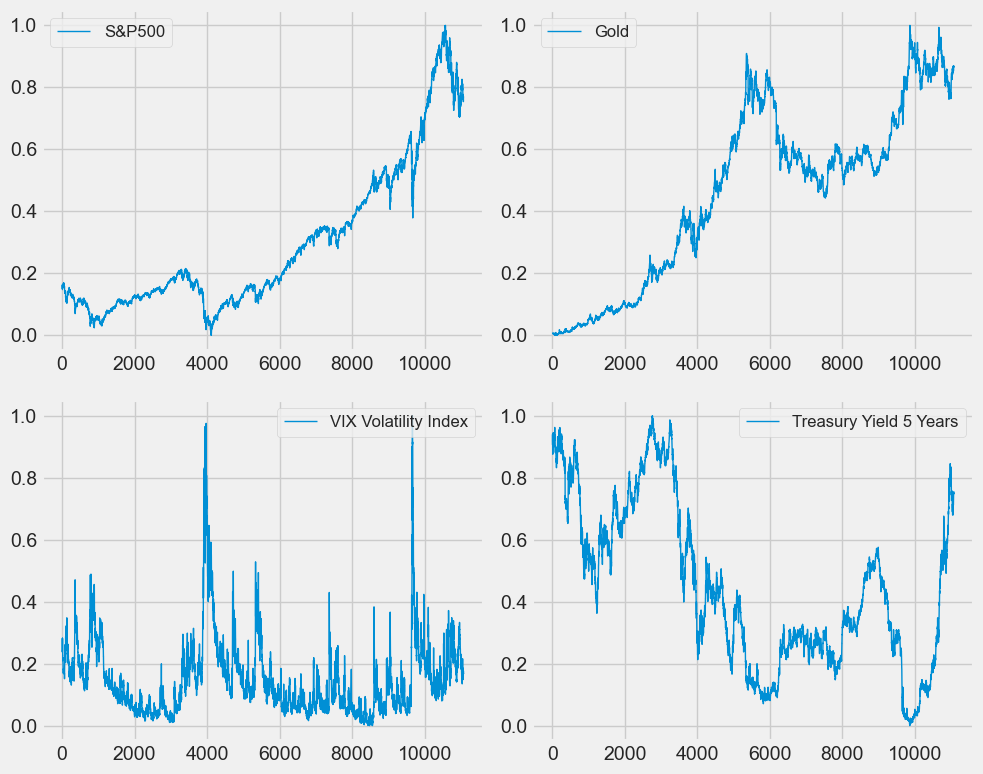

In [324]:
import sys
sys.path.insert(1, r"C:/Users/mihao/OneDrive - Univerza v Ljubljani/Doktorski_studij/Delo/Evolving transformer")
sys.path.insert(1, r"C:\Users\Miha\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\Evolving transformer")
from importlib import reload 
import data.dataclass_module as dataclass_module
reload(dataclass_module)

input_length = 150
output_length = 60
training_part = 0.8
output_steps_ahead = 1
database = dataclass_module.StockData(input_length,output_length,output_steps_ahead)
database.display_data_norm()

#print(database.data_dropped)
print(database.data_norm)

#print(database.datasnp_dropped)
scalar = database.scalar

database.dataset_input
database.dataset_output


In [325]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

'''
class Stockdataset(Dataset):
    def __init__(self, data, input_length, output_length = 1):
        self.data = data
        self.data = torch.from_numpy(data).float()#.view(-1)
        self.seq_len = input_length
        self.out_len = output_length

    def __len__(self):
        return len(self.data)-(self.seq_len+self.out_len+1)

    def __getitem__(self, index):
        return self.data[index : index+self.seq_len], self.data[index+self.seq_len+1: index+self.seq_len+self.out_len+1,0]
'''

training_part = 0.8

size_training = int(len(database.data_norm)*training_part)
size_valid = int((len(database.data_norm) - size_training)/2)
data_train, data_val, data_test = database.data_norm[0:size_training,:], database.data_norm[size_training:(len(database.data_norm)-size_valid),:], database.data_norm[(len(database.data_norm)-size_valid):,:]

print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

train_dataset = dataclass_module.Stockdataset(data_train, input_length, output_length)
valid_dataset = dataclass_module.Stockdataset(data_val, input_length, output_length)
test_dataset = dataclass_module.Stockdataset(data_test, input_length, output_length)
whole_dataset = dataclass_module.Stockdataset(database.data_norm, input_length, output_length)

print(test_dataset.__getitem__(1)[0].shape)
print(train_dataset.__getitem__(1)[0].shape)
print(whole_dataset.__getitem__(0)[0].shape)

training_batch_size = 313; #513
batch_size = training_batch_size
train_dataloader = DataLoader(train_dataset, batch_size, drop_last = True, shuffle=True) #drop_last = True ignores last batch is data is not divisable by batch_size
valid_dataloader = DataLoader(valid_dataset, batch_size, drop_last = True, shuffle=True) #drop_last = True ignores last batch is data is not divisable by batch_size
test_dataloader = DataLoader(test_dataset, batch_size, drop_last = True, shuffle=True)

whole_dataloader = DataLoader(whole_dataset, batch_size, drop_last = True, shuffle=False)
#whole_dataloader = DataLoader(train_dataset, 1, drop_last = False)

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the current selected device
    device = torch.device('cuda')

    # Calculate memory details (in bytes)
    total_memory = torch.cuda.get_device_properties(device).total_memory
    allocated_memory = torch.cuda.memory_allocated(device)
    available_memory = total_memory - allocated_memory

    # Convert bytes to GB
    total_memory_GB = total_memory / (1024 ** 3)
    allocated_memory_GB = allocated_memory / (1024 ** 3)
    available_memory_GB = available_memory / (1024 ** 3)

    print(f"Total memory on GPU: {total_memory_GB} GB")
    print(f"Allocated memory on GPU: {allocated_memory_GB} GB")
    print(f"Available memory on GPU: {available_memory_GB} GB")

    # If available memory is less than 2GB, use CPU
    if available_memory_GB < 2:
        device = torch.device('cpu')

else:
    # If CUDA is not available, use CPU
    device = torch.device('cpu')

print(f"Using device: {device}")



(8858, 4)
(1108, 4)
(1107, 4)
torch.Size([150, 4])
torch.Size([150, 4])
torch.Size([150, 4])
Total memory on GPU: 5.99957275390625 GB
Allocated memory on GPU: 0.006886005401611328 GB
Available memory on GPU: 5.992686748504639 GB
Using device: cuda


In [326]:
class LSTMSeq2SeqForecastingNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim=1, dropout_rate=0.1):
        super(LSTMSeq2SeqForecastingNetwork, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        
        # Output layer
        self.fc_out = nn.Linear(hidden_dim, output_dim)

        # Define the dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Define the layer normalization
        self.ln = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        
        # Output layer
        y = self.fc_out(lstm_out)

        return y[:, -output_length:]


In [327]:
import torch.optim as optim

# Hyperparameters
input_dim = 4
output_length = output_length
hidden_dim = 256
num_layers = 3
dropout_rate = 0.1
num_epochs = 200

model = LSTMSeq2SeqForecastingNetwork(input_dim, hidden_dim, num_layers, 1, dropout_rate).to(device)
learning_rate = 0.001  # or any other value
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

In [328]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import mean_absolute_error, mean_squared_error

def test(dataloader):
    model.eval()
    test_loss = 0
    all_y = []
    all_out = []
    
    # Close all previous figures
    clear_output(wait=True)

    # Create a new figure
    plt.figure(figsize=(10, 5))

    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)
            
            out = model(x)
            test_loss += loss_fn(out, y.unsqueeze(2)).item()

            # Append the data for MAE, RMSE, MSE, and NRMSE computation
            all_y.append(y.cpu().numpy())
            all_out.append(out.squeeze(2).cpu().numpy())
            
            # For visualization, just take the first sequence in the batch
            y = y[0].cpu().numpy()
            out = out[0].cpu().numpy()

            # Plot the true and predicted sequences with specified colors
            plt.plot(range(len(y)), y, color='blue', label='True' if i == 0 else "")
            plt.plot(range(len(out)), out, color='red', label='Pred' if i == 0 else "")



    # Show the legend and the plot
    plt.legend()
    plt.show()

    test_loss /= len(dataloader)
    print(f'Test Loss: {test_loss:.4f}')

    # Compute and print MAE, RMSE, MSE, and NRMSE
    all_y = np.concatenate(all_y)
    all_out = np.concatenate(all_out)

    mae = mean_absolute_error(all_y, all_out)
    mse = mean_squared_error(all_y, all_out)
    rmse = np.sqrt(mse)
    nrmse = rmse / np.std(all_y)
    print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, NRMSE: {nrmse:.4f}')
    return mae, mse, rmse, nrmse


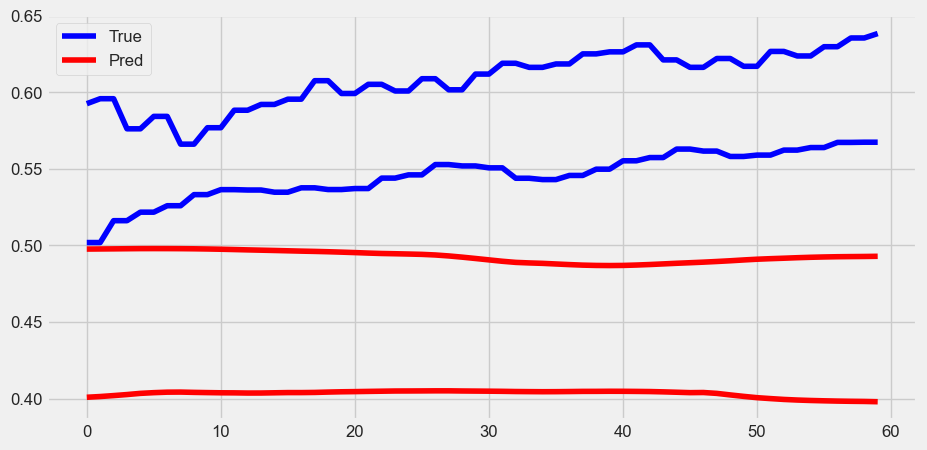

Test Loss: 0.0180
MAE: 0.1092, MSE: 0.0180, RMSE: 0.1341, NRMSE: 2.2855


In [329]:
# Training
MSE_min = 10
for epoch in range(num_epochs):
    loss_sum = 0

    for batch, (x, y) in enumerate(train_dataloader):
        model.train()

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        
        out = model(x)

        loss = loss_fn(out, y.unsqueeze(2))
        loss.backward()
        
        optimizer.step()
        
        loss_sum += loss.item()

    print(f"Epoch {epoch}, training loss: {loss_sum/len(train_dataloader)}")
    if (epoch+1) % 5 == 0:
        mae, mse, rmse, nrmse = test(valid_dataloader)
        if MSE_min > mse:
            MSE_min = mse
            print(f'Save model loss MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, NRMSE: {nrmse:.4f}')
            torch.save(model, f"model_LSTM_{input_length}_{output_length}_{hidden_dim}_{num_layers}.pt")



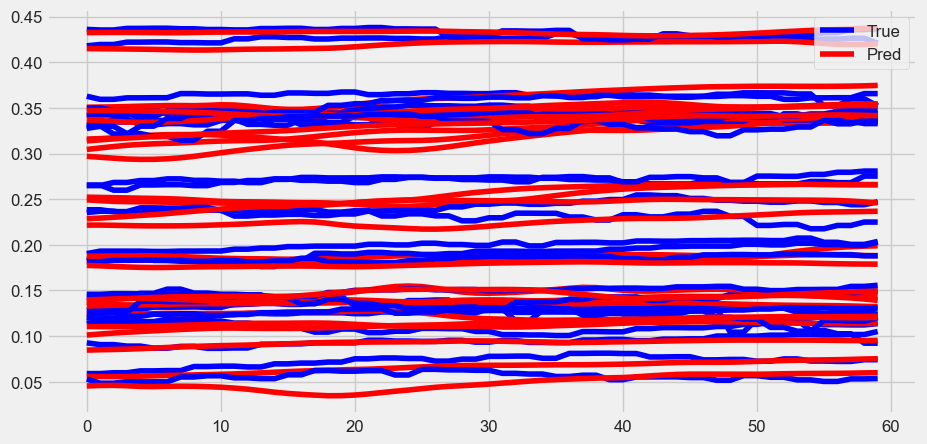

Test Loss: 0.0003
MAE: 0.0120, MSE: 0.0003, RMSE: 0.0163, NRMSE: 0.1365


In [330]:
# Testing
name = f"model_LSTM_{input_length}_{output_length}_{hidden_dim}_{num_layers}.pt"
print(name)
model = torch.load(name, map_location=torch.device(device))
model.eval()
mae_train, mse_train, rmse_train, nrmse_train  = test(train_dataloader)

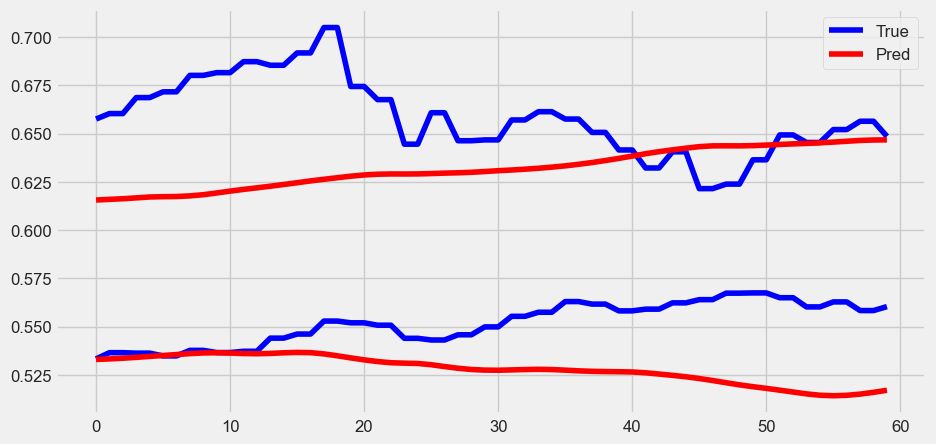

Test Loss: 0.0024
MAE: 0.0358, MSE: 0.0024, RMSE: 0.0492, NRMSE: 0.8280


In [331]:
mae_valid, mse_valid, rmse_valid, nrmse_valid  = test(valid_dataloader)


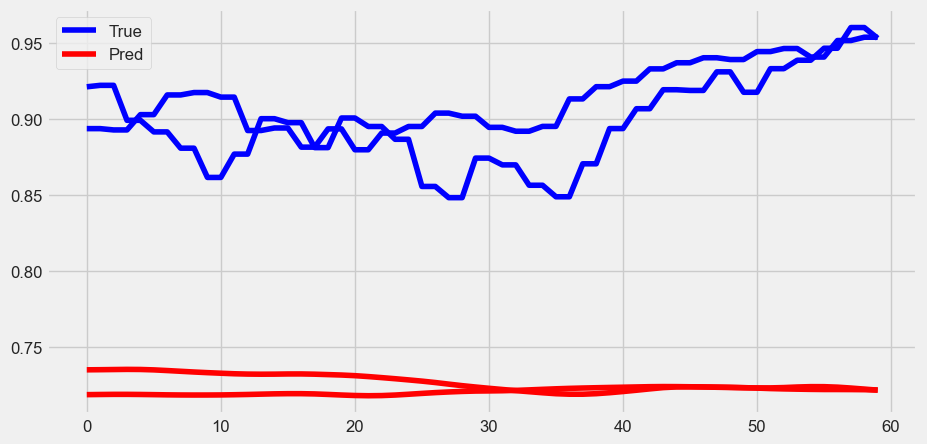

Test Loss: 0.0283
MAE: 0.1571, MSE: 0.0283, RMSE: 0.1683, NRMSE: 2.3680


In [332]:
mae_test, mse_test, rmse_test, nrmse_test  = test(test_dataloader)


In [333]:
'''
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

from IPython.display import clear_output
# Suppress warnings
warnings.filterwarnings("ignore")

# Specify the order (p, d, q) of the ARIMA model
order = (30,1,10)

# Split the data into training and validation sets
size_training = int(len(database.data_norm)*0.80)
size_test = len(database.data_norm) - size_training
data_train, data_val = database.data_norm[0:size_training,0], database.data_norm[size_training:len(database.data_norm),0]


def predict_and_evaluate(data, dataset_name):
    predictions = []
    actuals = []
    plt.figure(figsize=(10, 5))

    # Initialize lists to store the training data and forecasts
    training_data_list = []
    forecasts_list = []

    for t in range(input_length, len(data) - output_length, output_length):
        # Create the input sequence
        input_seq = data[t-input_length:t]

        # Define the ARIMA model and fit it to the input sequence
        model = ARIMA(input_seq, order=order)
        model_fit = model.fit()
        
        # Make output_length-step-ahead forecasts
        forecast = model_fit.forecast(steps=output_length)

        # Store the forecasts
        predictions.extend(forecast)
        actuals.extend(data[t:t+output_length])

        # Only save and plot the data every 'input_length' time steps
        if t % output_length == 0:
            # Save the training data and the forecast
            training_data = np.arange(t - input_length, t), data[(t - input_length):t]
            training_data_list.append(training_data)
            forecast_data = np.arange(t, t + output_length), forecast
            forecasts_list.append(forecast_data)

            # Clear the output of the cell
            clear_output(wait=True)
            
            # Plot the training data and forecasts
            for j in range(len(training_data_list)):
                plt.plot(training_data_list[j][0], training_data_list[j][1],'b', label=f'Training Data at t={j*input_length}')
                plt.plot(forecasts_list[j][0], forecasts_list[j][1],'r', label=f'Forecast at t={j*input_length}')

            plt.show()

    # Clear the current figure's content
    plt.clf()
    clear_output(wait=True)
    # Plot the true and predicted sequences
    plt.plot(range(len(actuals)), actuals, color='blue', label='True')
    plt.plot(range(len(predictions)), predictions, color='red', label='Pred')

    # Legend and title
    plt.legend()
    plt.title(dataset_name)
    plt.show()

    # Display the updated plot
    plt.pause(0.01)

    # Compute and print MAE, MSE, RMSE, and NRMSE
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)

    print(f'{dataset_name} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}')

#predict_and_evaluate(data_train, 'Training Set')
predict_and_evaluate(data_val, 'Validation Set')
'''

'\nfrom statsmodels.tsa.arima.model import ARIMA\nimport matplotlib.pyplot as plt\nimport numpy as np\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error\nimport warnings\n\nfrom IPython.display import clear_output\n# Suppress warnings\nwarnings.filterwarnings("ignore")\n\n# Specify the order (p, d, q) of the ARIMA model\norder = (30,1,10)\n\n# Split the data into training and validation sets\nsize_training = int(len(database.data_norm)*0.80)\nsize_test = len(database.data_norm) - size_training\ndata_train, data_val = database.data_norm[0:size_training,0], database.data_norm[size_training:len(database.data_norm),0]\n\n\ndef predict_and_evaluate(data, dataset_name):\n    predictions = []\n    actuals = []\n    plt.figure(figsize=(10, 5))\n\n    # Initialize lists to store the training data and forecasts\n    training_data_list = []\n    forecasts_list = []\n\n    for t in range(input_length, len(data) - output_length, output_length):\n        # Create the input sequence

In [334]:
'''
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima
from pandas import read_csv
import matplotlib.pyplot as plt
from IPython.display import clear_output

# load the dataset
size_training = int(len(database.data_norm)*training_part)
size_test = len(database.data_norm) - size_training
data_train, data_val = database.data_norm[0:size_training,0], database.data_norm[size_training:len(database.data_norm),0]

# Fit auto_arima function to 'data_train'
model = auto_arima(data_train, start_p = 5, start_q = 1,  start_d = 1, 
                          max_p = 10, max_q = 3,
                          seasonal = False, trace = True,
                          error_action ='ignore',   # don't want to know if an order does not work
                          suppress_warnings = True,  # don't want convergence warnings
                          stepwise = True)           # set to stepwise
model.fit(data_train)

# To print the summary
model.summary()

# Initialize lists to store the training data and forecasts
training_data_list = []
forecasts_list = []

# Generate 'output_length' forecasts at each step of 'data_val', using a rolling window of 'input_length' samples
for i in range(input_length, len(data_val)):
    # Retrain the model with the new window and generate the forecast
    model.update(data_val[(i-input_length):i])
    forecast = model.predict(n_periods=output_length)

    # Only save and plot the data every 'input_length' time steps
    if i % input_length == 0:
        # Save the training data and the forecast
        training_data = np.arange(i - input_length, i), data_val[(i - input_length):i]
        training_data_list.append(training_data)
        forecast_data = np.arange(i, i + output_length), forecast
        forecasts_list.append(forecast_data)

        # Clear the output of the cell
        clear_output(wait=True)
        
        # Plot the training data and forecasts
        for j in range(len(training_data_list)):
            plt.plot(training_data_list[j][0], training_data_list[j][1], label=f'Training Data at i={j*input_length}')
            plt.plot(forecasts_list[j][0], forecasts_list[j][1], label=f'Forecast at i={j*input_length}')

        plt.legend(loc='upper left', fontsize=8)
        plt.show()
'''

"\nimport numpy as np\nfrom sklearn.preprocessing import MinMaxScaler\nfrom pmdarima import auto_arima\nfrom pandas import read_csv\nimport matplotlib.pyplot as plt\nfrom IPython.display import clear_output\n\n# load the dataset\nsize_training = int(len(database.data_norm)*training_part)\nsize_test = len(database.data_norm) - size_training\ndata_train, data_val = database.data_norm[0:size_training,0], database.data_norm[size_training:len(database.data_norm),0]\n\n# Fit auto_arima function to 'data_train'\nmodel = auto_arima(data_train, start_p = 5, start_q = 1,  start_d = 1, \n                          max_p = 10, max_q = 3,\n                          seasonal = False, trace = True,\n                          error_action ='ignore',   # don't want to know if an order does not work\n                          suppress_warnings = True,  # don't want convergence warnings\n                          stepwise = True)           # set to stepwise\nmodel.fit(data_train)\n\n# To print the summary

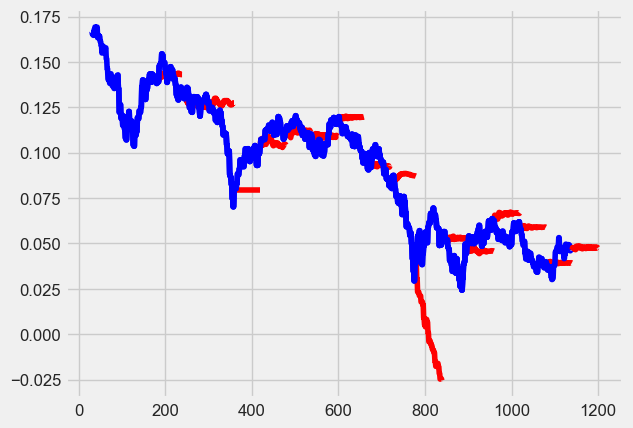

Training Set - MAE: 0.0108, MSE: 0.0002, RMSE: 0.0147
Time step 1141
Time step 1142
Time step 1143
Time step 1144
Time step 1145
Time step 1146
Time step 1147
Time step 1148
Time step 1149
Time step 1150
Time step 1151
Time step 1152
Time step 1153
Time step 1154
Time step 1155
Time step 1156
Time step 1157
Time step 1158
Time step 1159
Time step 1160
Time step 1161
Time step 1162
Time step 1163
Time step 1164


In [335]:

from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

from IPython.display import clear_output
# Suppress warnings
warnings.filterwarnings("ignore")

# Specify the order (p, d, q) of the ARIMA model
order = (30,1,1)

# Split the data into training and validation sets
size_training = int(len(database.data_norm)*training_part)

size_valid = int((len(database.data_norm) - size_training)/2)
data_train, data_val, data_test = database.data_norm[0:size_training,0], database.data_norm[size_training:(len(database.data_norm)-size_valid),0], database.data_norm[(len(database.data_norm)-size_valid):,0]

def predict_and_evaluate(data, dataset_name):
    predictions = []
    actuals = []
    plt.figure(figsize=(10, 5))

    # Initialize lists to store the training data and forecasts
    training_data_list = []
    forecasts_list = []

    for t in range(input_length, len(data) - output_length):
        # Create the input sequence
        input_seq = data[t-input_length:t]

        # Define the ARIMA model and fit it to the input sequence
        model = ARIMA(input_seq, order=order)
        model.initialize_approximate_diffuse()
        model_fit = model.fit()
        
        # Make output_length-step-ahead forecasts
        forecast = model_fit.forecast(steps=output_length)

        # Store the forecasts
        predictions.extend(forecast)
        actuals.extend(data[t:t+output_length])
        print(f"Time step {t}")
        # Only save and plot the data every 'input_length' time steps
        if  (t % output_length == 0):
                
            # Save the training data and the forecast
            training_data = np.arange(t - input_length, t), data[(t - input_length):t]
            training_data_list.append(training_data)
            forecast_data = np.arange(t, t + output_length), forecast
            forecasts_list.append(forecast_data)

            # Clear the output of the cell
            clear_output(wait=True)
            
            # Plot the training data and forecasts
            for j in range(len(training_data_list)):
                plt.plot(training_data_list[j][0], training_data_list[j][1],'b', label=f'Training Data at t={j*input_length}')
                plt.plot(forecasts_list[j][0], forecasts_list[j][1],'r', label=f'Forecast at t={j*input_length}')

            plt.show()
            # Display the updated plot
            plt.pause(0.01)
            # Compute and print MAE, MSE, RMSE, and NRMSE
            mae = mean_absolute_error(actuals, predictions)
            mse = mean_squared_error(actuals, predictions)
            rmse = np.sqrt(mse)

            print(f'{dataset_name} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}') 

    # Clear the current figure's content
    plt.clf()
    clear_output(wait=True)
    # Plot the true and predicted sequences
    plt.plot(range(len(actuals)), actuals, color='blue', label='True')
    plt.plot(range(len(predictions)), predictions, color='red', label='Pred')

    # Legend and title
    plt.legend()
    plt.title(dataset_name)
    plt.show()

    # Display the updated plot
    plt.pause(0.01)

    # Compute and print MAE, MSE, RMSE, and NRMSE
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)

    print(f'{dataset_name} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}')

predict_and_evaluate(data_train, 'Training Set')

In [ ]:
predict_and_evaluate(data_val, 'Validation Set')


KeyboardInterrupt: 

<Figure size 1000x500 with 0 Axes>

In [ ]:
predict_and_evaluate(data_test, 'Testing Set')